#### What is this notebook?

This notebook is made for running parameter experiments. Since I have taken out the hard coded numerical variables, I gathered it in a `parameters.json` file and here.  When the model is basically done, you can run the experiments here rather easily.

#### Cell 1: Manage file system


Simulation Year 0
Last year:130
village has 0 new born.

Simulation Year 1
Last year:130
village has 1 new born.

Simulation Year 2
Last year:131
village has 6 new born.

Simulation Year 3
Last year:137
village has 19 new born.

Simulation Year 4
Last year:148
village has 13 new born.

Simulation Year 5
Last year:156
village has 23 new born.

Simulation Year 6
Last year:169
village has 30 new born.

Simulation Year 7
Last year:186
village has 28 new born.

Simulation Year 8
Last year:199
village has 27 new born.

Simulation Year 9
Last year:213
village has 30 new born.

Simulation Year 10
Last year:231
village has 35 new born.

Simulation Year 11
Last year:248
village has 44 new born.

Simulation Year 12
Last year:270
village has 33 new born.

Simulation Year 13
Last year:288
village has 32 new born.

Simulation Year 14
Last year:306
village has 27 new born.

Simulation Year 15
Last year:319
village has 29 new born.

Simulation Year 16
Last year:335
village has 37 new born.

Simulatio

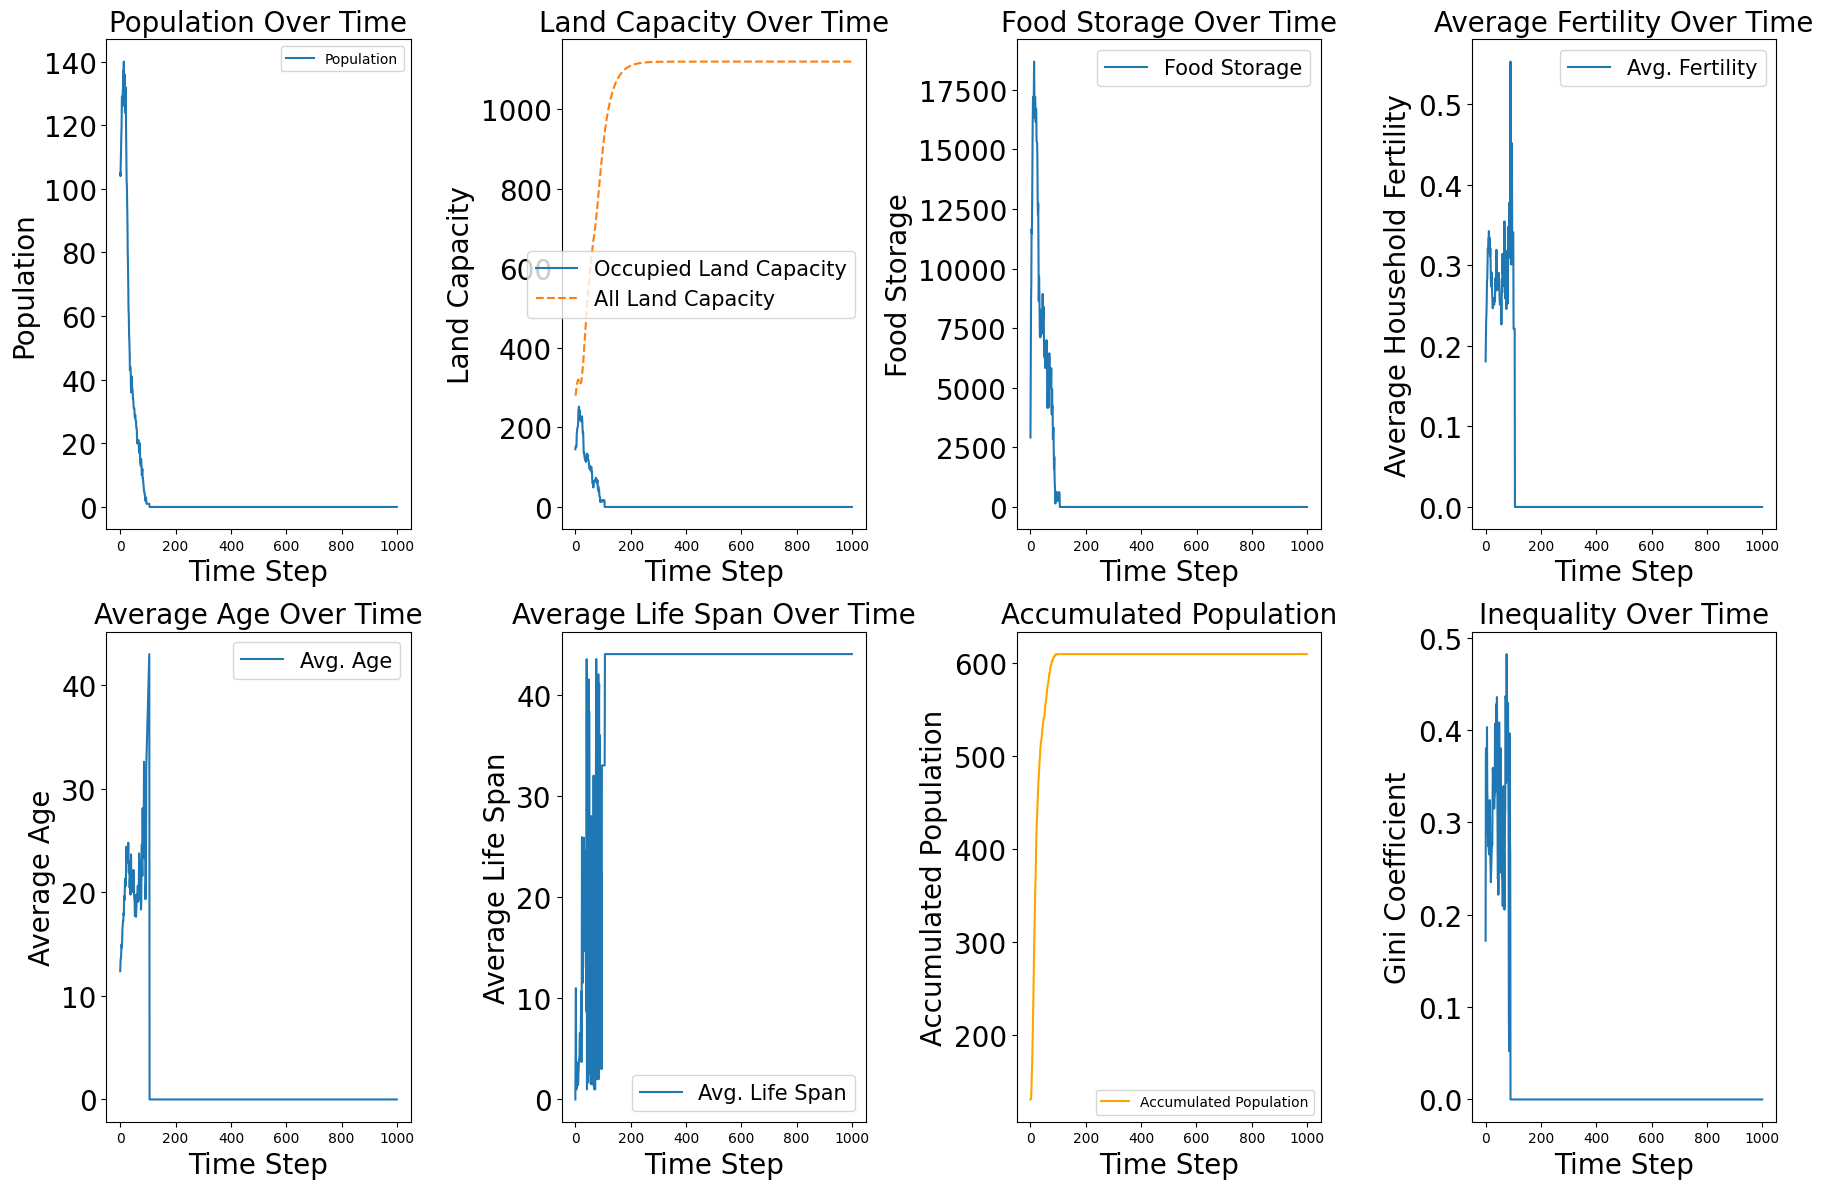

In [1]:
from variables import *
import os
import datetime
from IPython.display import clear_output
timestamp = datetime.datetime.now().strftime("%d-%m-%Y&%H-%M-%S")
folder_name = f"run_results/{timestamp}"
file_name = f"{folder_name}/{file_name}"
file_path = f"{folder_name}/{file_path}"
os.makedirs(folder_name, exist_ok=True)
with open(os.path.join(folder_name, "parameters.json"), "w") as f:
    json.dump(params, f, indent=4)
    
%run main.py